In [1]:
import pandas as pd

df_clean = pd.read_csv('./data_clean.csv')

In [2]:
for column in df_clean.columns:
    print(column, '|', df_clean[column].nunique(), '|', df_clean[column].dtype)

price | 12885 | int64
manufacturer | 41 | object
model | 10619 | object
cylinders | 8 | object
fuel | 5 | object
odometer | 81155 | float64
title_status | 6 | object
transmission | 3 | object
type_of_drive | 4 | object
size | 5 | object
generic_type | 13 | object
color | 13 | object
state_of_listing | 51 | object
year_to_now | 103 | float64


## Encoding:

#### Label Encoding: cylinders, size

#### One-hot encoding (categorical but small number of unique value): fuel, title_status, transmission, type_of_drive, generic_type, color

#### Target encoding (categorical but huge number of unique value): manufacturer, model, state_of_listing

### Split response and predictive variables first

In [3]:
y = df_clean['price']

X = df_clean.drop('price', axis = 1)

# Distribution transformation 

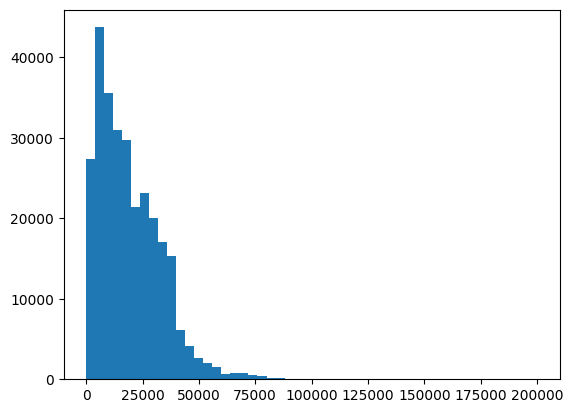

In [4]:
# Check price (reponse variable)
import matplotlib.pyplot as plt
plt.hist(df_clean['price'], bins = 50)
plt.show()


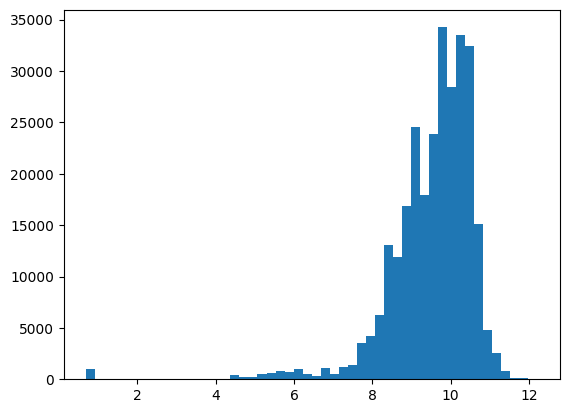

In [5]:
# We now should transform that 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
y_transformed = np.log1p(y)

plt.hist(y_transformed, bins = 50)
plt.show()

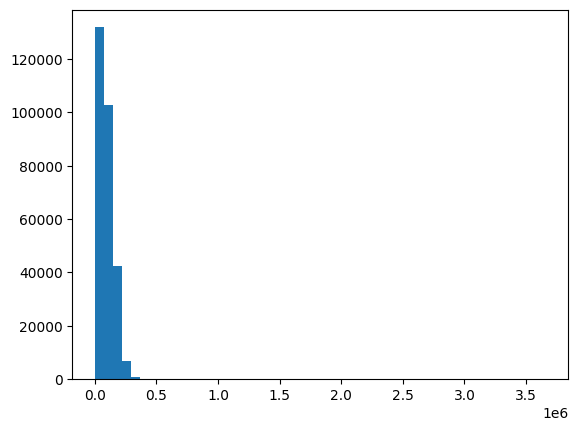

In [6]:
# Also test for odometer

plt.hist(df_clean['odometer'], bins = 50)
plt.show()

=> We also need to transform this using log 

# Split train/ test data and make any transformation

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_transformed,
    test_size = 0.2,
    random_state=42
)

### Define group of column

Label Encoding: cylinders, size

One-hot encoding (categorical but small number of unique value): fuel, title_status, transmission, type_of_drive, generic_type, color

Target encoding (categorical but huge number of unique value): manufacturer, model, state_of_listing

StandardScaler: year_to_now, odometer(with transformation)

In [8]:
print(X_train.columns.tolist())

# Just need for scale
numerical_cols = ['year_to_now']

log_scale_cols = ['odometer']

# One-hot
one_hot_cols = [
    'fuel', 
    'title_status', 
    'transmission', 
    'type_of_drive', 
    'generic_type', 
    'color'
]

# Target
target_encode_cols = ['manufacturer', 'model', 'state_of_listing']

# Label Encoding
size_map = ['other', 'sub-compact', 'compact', 'mid-size', 'full-size']
cylinder_map = ['other', '3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders']

ordinal_cols = ['size', 'cylinders']
ordinal_categories = [size_map, cylinder_map]

['manufacturer', 'model', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'type_of_drive', 'size', 'generic_type', 'color', 'state_of_listing', 'year_to_now']


### Build Pipeline

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer


# Tackle Scaling
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

log_scale_transformer = Pipeline(steps = [
    ('log', FunctionTransformer(np.log1p, feature_names_out = 'one-to-one')),
    ('scaler',StandardScaler())
])

# Label encoding
ordinal_transformer = Pipeline(steps = [
    ('ordinal',OrdinalEncoder(categories = ordinal_categories))
])

# One-hot encoding
onehot_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Target encoding
target_transformer = Pipeline(steps = [
    ('target',TargetEncoder())
])

# Grab all them up to create a process
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numerical_cols),

        ('log_num',log_scale_transformer, log_scale_cols),

        ('ord', ordinal_transformer, ordinal_cols),
        ('ohe', onehot_transformer, one_hot_cols),
        ('te',target_transformer, target_encode_cols)
    ], remainder = 'passthrough'
)

## Save processing transform and save new file

In [10]:
import joblib # save the process
import pandas as pd
import os

# Transform the data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
print(f"Shape X_train: {X_train_transformed.shape}")

X_test_transformed = preprocessor.transform(X_test)
print(f"Shape X_test: {X_test_transformed.shape}")

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('data_csv', exist_ok=True)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# --- DEBUGGING CODE ---
print(f"🕵️‍♂️ Bắt đầu kiểm tra...")
print(f"Shape của mảng X_train_transformed: {X_train_transformed.shape}")
print(f"Số lượng tên trong feature_names: {len(feature_names)}")
print(f"Type of X_train_transformed: {type(X_train_transformed)}")

# Check if it's a sparse matrix
from scipy import sparse
if sparse.issparse(X_train_transformed):
    print("⚠️ X_train_transformed là sparse matrix!")
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()
    print(f"Đã convert sang dense array. New shape: {X_train_transformed.shape}")

# Normal case - dimensions match
X_train_final_df = pd.DataFrame(
    X_train_transformed,
    columns=feature_names
)
X_test_final_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names
)

# Save everything
joblib.dump(preprocessor, 'models/preprocessor.pkl')

X_train_final_df.to_csv('data_csv/X_train_final.csv', index=False)
X_test_final_df.to_csv('data_csv/X_test_final.csv', index=False)

y_train.to_csv('data_csv/y_train_final.csv', index=False)
y_test.to_csv('data_csv/y_test_final.csv', index=False)

print(f"Final shape - X_train: {X_train_final_df.shape}, X_test: {X_test_final_df.shape}")

Shape X_train: (227986, 51)
Shape X_test: (56997, 51)
🕵️‍♂️ Bắt đầu kiểm tra...
Shape của mảng X_train_transformed: (227986, 51)
Số lượng tên trong feature_names: 51
Type of X_train_transformed: <class 'scipy.sparse._csr.csr_matrix'>
⚠️ X_train_transformed là sparse matrix!
Đã convert sang dense array. New shape: (227986, 51)
Final shape - X_train: (227986, 51), X_test: (56997, 51)
